# Tutorial

This notebook gives a basic idea how the CRISPRzip model is structured and how it can be used to make predictions about Cas9 activity.


### Preparation steps (using a terminal)

1. Clone the repository and relocate to its corresponding directory

```bash 
git clone git@github.com:hiddeoff/crisprzip.git
cd crisprzip
```

2. Unless already done, install the crisprzip package
```bash
python3 -m venv venv
source venv/bin/activate
pip install crisprzip
```

### Tutorial start (using this notebook)

Import packages

In [2]:
import os
import crisprzip

Verify working directory. If this tutorial was opened from the cloned repository, instruction below should print something like `crisprzip/examples`

In [3]:
print(os.getcwd())

/crisprzip/examples


Regardless of the output above, the code below will find the root directory of the git repository starting from the current working directory of the Jupyter Notebook. This step is essential so that files in `data` can be found

In [5]:
import os
from pathlib import Path

def find_git_root(path):
    while not os.path.isdir(os.path.join(path, '.git')):
        parent = os.path.dirname(path)
        if parent == path:
            raise FileNotFoundError("No .git directory found")
        path = parent
    return path

# navigate to source root
current_dir = Path().resolve()
rootdir = find_git_root(current_dir)
os.chdir(rootdir)

In [6]:
print(rootdir)
print(os.getcwd())

/crisprzip
/crisprzip


## 1 Generate R-loop landscapes
### 1.1 Specify protospacer and targets
Let's say you use CRISPR-Cas9 to target the sequence `5'-GACGCATAAAGATGAGACGCTGG-3'` and want to understand its dynamics on the on-target and on some potential off-targets. We specify them below.

In [7]:
guide_rna   =   "GACGCATAAAGATGAGACGC"     # 5'-to-3'
protospacer =  "AGACGCATAAAGATGAGACGCTGG"  # 5'-to-3', with 5' flanking NT (optional) and 3' PAM (NGG)

targets     = [protospacer,                 # on-target
               "AGTCGCATAAAGATGAGACGCGGG",  # off-target 1: A19T           (GGG PAM)
               "AGACCCATTAAGATGAGACGCGGG",  # off-target 2: A13T G17C      (GGG PAM)
               "AGACGCATAACTATGAGACGCAGG",  # off-target 3: G10T A11C      (AGG PAM)
               "AGACGCATAAAGATAAGCGGCCGG"]  # off-target 4: C03G A04C G07A (CGG PAM)

### 1.2 Choose a parameter set
#### 1.2.1 Sequence-averaged model
In CRISPRzip, you simulate the dynamics by constructing an energy landscape of the R-loop formation process. For this, we need to choose a parameter set that contains all the energy contributions. To start, let's use a simpler version of the model that only considers the positions of mismatches (without sequence content).

In [8]:
import json
from crisprzip.kinetics import *

# loading a parameter set for the energy landscape model
with open('data/landscapes/average_params.json', 'r') as file:
    average_params = json.load(file)['param_values']

# the Searcher object defines the energy landscapes
protein = Searcher(**average_params)

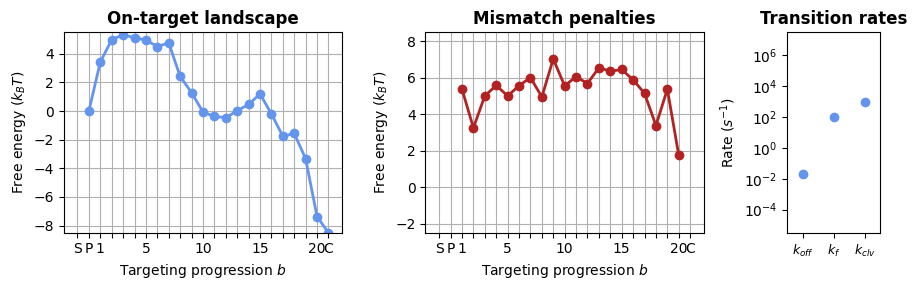

In [9]:
import matplotlib.pyplot as plt
from crisprzip.plotting import SearcherPlotter

# visualizing the parameter set
_, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

With the above parameter sets, we can construct the energy landscape for any target by adding the appropriate mismatch penalties to the on-target landscape. The SearcherTargetComplex object generates off-target landscapes - and can do calculations on the basis of these, which we'll get to in [section 2](#predicting-activity).

In [10]:
protein_target_complexes = []
for target_seq in targets:
    mm_pattern = (GuideTargetHybrid
                  .from_cas9_offtarget(target_seq, protospacer)
                  .get_mismatch_pattern())
    protein_target_complexes += [protein.probe_target(mm_pattern)]

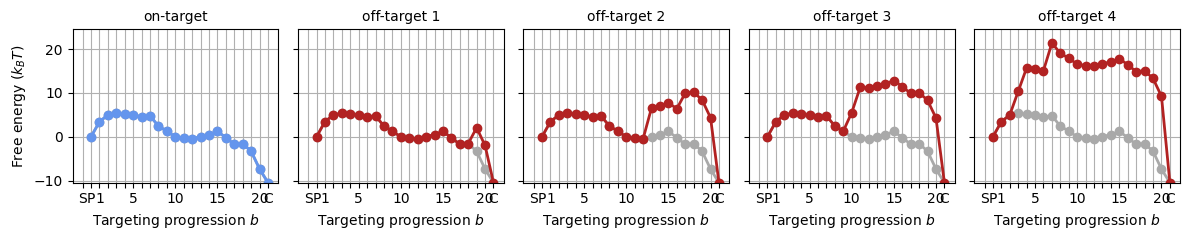

In [11]:
_, axes = plt.subplots(1, 5, figsize=(12, 2.5), sharey='all')
for i, ptc in enumerate(protein_target_complexes):
    SearcherPlotter(ptc).plot_off_target_landscape(axs=axes[i], y_lims=(-10, 24))

    if i == 0:
        axes[i].get_lines()[1].set_color('cornflowerblue')
        axes[i].set_title('on-target', fontsize='medium')
    else:
        axes[i].set_ylabel('')
        axes[i].set_title(f"off-target {i:d}", fontsize='medium')

plt.tight_layout()

For clarity, the 'mismatch patterns' that the above landscapes are based on relate to the gRNA and target sequence as illustrated below.

In [13]:
hybrid = GuideTargetHybrid.from_cas9_offtarget(targets[1], protospacer)
hybrid.set_rloop_state(20)
print("\n".join([
    'R-loop visualization:',
    '',
    str(hybrid),
    '',
    f"Mismatch pattern: {str(hybrid.get_mismatch_pattern())}  (3'-to-5')",
]))

R-loop visualization:

 5'-GACGCAUAAAGAUGAGACGC-3'  (RNA guide)
    |·||||||||||||||||||
3'-TCAGCGTATTTCTACTCTGCGC-5' (DNA TS)
   |                    |
5'-AGTCGCATAAAGATGAGACGCG-3' (DNA NTS)
    20   15   10   5   1

Mismatch pattern: 00000000000000000010  (3'-to-5')


#### 1.2.2 Sequence-specific model
CRISPRzip can consider the sequence of the gRNA and target into account when calculating off-target landscapes. Using a sequence-specific model will give different activity predictions for off-targets that have the same mismatch pattern but a different sequence (e.g. A04T vs A04G).

The off-target landscapes will not only include the energy contributions from the protein (internal stability, NA backbone interactions), but will add the expected free energy cost of the R-loop. This R-loop cost is calculated in the module `nucleic_acid.py`. To support this addition of the R-loop cost, we should switch from the 'Searcher' and 'SearcherTargetComplex' object to a 'BareSearcher', 'GuidedSearcher' and 'SearcherSeqeunceComplex', as they add this energy in the calculation of the off-target landscape.

In [14]:
import json
from crisprzip.kinetics import *

# loading a parameter set for the energy landscape model
with open('data/landscapes/sequence_params.json', 'r') as file:
    sequence_params = json.load(file)['param_values']

# the BareSearcher object defines the energy landscapes
bare_protein = BareSearcher(**sequence_params)
# the GuidedSearcher has an attribute for the protospacer, reflecting the gRNA loading
guided_protein = GuidedSearcher(**sequence_params, protospacer=protospacer)

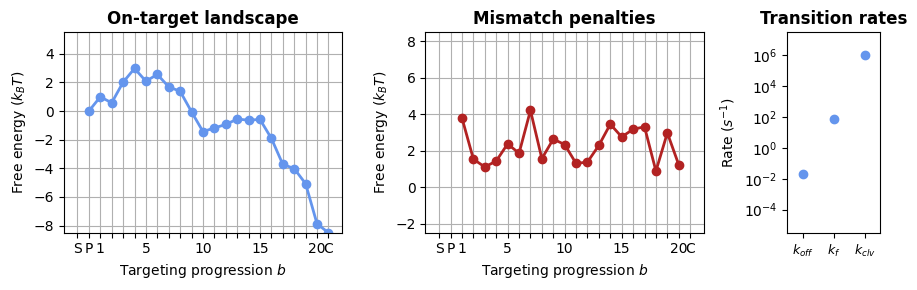

In [15]:
import matplotlib.pyplot as plt
from crisprzip.plotting import SearcherPlotter

# visualizing the parameter set
_, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(bare_protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(bare_protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(bare_protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

These landscapes clearly differ from those in the sequence-averaged model! The difference is that these are only the protein contributions; when the R-loop cost is added below, these landscapes will look a lot more similar to those above.

Again, we construct the energy landscape for various targets. The 'ProteinSequenceComplex' takes the off-target _sequences_ as an input, and handles the addition of the R-loop cost, and apart from that, it is identical to the (sequence-independent) 'ProteinTargetComplex'.

In [16]:
import crisprzip

protein_sequence_complexes = []
for target_seq in targets:
    protein_sequence_complexes += [guided_protein.probe_sequence(target_seq)]

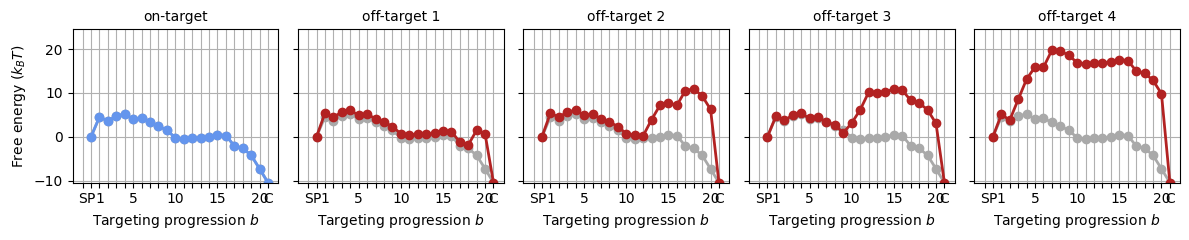

In [17]:
_, axes = plt.subplots(1, 5, figsize=(12, 2.5), sharey='all')
for i, psc in enumerate(protein_sequence_complexes):
    SearcherPlotter(psc).plot_off_target_landscape(axs=axes[i], y_lims=(-10, 24))

    if i == 0:
        axes[i].get_lines()[1].set_color('cornflowerblue')
        axes[i].set_title('on-target', fontsize='medium')
    else:
        axes[i].set_ylabel('')
        axes[i].set_title(f"off-target {i:d}", fontsize='medium')

plt.tight_layout()

These landscapes are very similar to the landscapes generated by the sequence-averaged model, however, there are small deviations as a result of the base contents. We'll stick by these landscapes in the tutorial from here on.

## 2 Predicting activity
### 2.1 Cleavage activity
We can use the landscapes generated above to make predictions about Cas9 activity.

If we look at the cleavage process, we see that any target gets cleaved but the rate at which this happens varies greatly. Often, it makes sense fitting an exponential decay function to the population of cleavage products to obtain an effective cleavage rate. We demonstrate this below for the on-target.

In [18]:
# USER INPUT

# 'k_on_ref' is the association rate at 1 nM (s⁻¹)
k_on_ref = 1E-2
concentration = 5

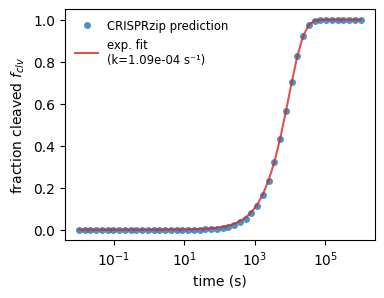

In [19]:
from scipy.optimize import curve_fit

_, axs_fit = plt.subplots(1, 1, figsize=(4, 3))

def get_cleavage_rate(stc, binding_rate):
    dt = np.logspace(-2, 6)
    f_clv = stc.get_cleaved_fraction(dt, binding_rate)
    with np.errstate(over='ignore'): # ignore RuntimeWarning: overflow
        k_eff = curve_fit(
            f=lambda t, k: 1 - np.exp(-k * t),
            xdata=dt,
            ydata=f_clv,
        )[0][0]
    return k_eff

stc0 = protein_sequence_complexes[3]
kfit0 = get_cleavage_rate(stc0, k_on_ref)
axs_fit.plot(
    np.logspace(-2, 6),
    stc0.get_cleaved_fraction(np.logspace(-2, 6), k_on_ref),
    marker='o', ls='None', markersize=5, markeredgecolor='None',
    label='CRISPRzip prediction',
    alpha=.8
)
axs_fit.plot(
    np.logspace(-2, 6),
    1 - np.exp(-kfit0 * np.logspace(-2, 6)),
    color='tab:red', alpha=.8,
    label=f'exp. fit\n(k={kfit0:.2e} s⁻¹)'
)
axs_fit.set_xscale('log')
axs_fit.set_xlabel('time (s)')
axs_fit.set_ylabel('fraction cleaved $f_{clv}$')
axs_fit.legend(fontsize='small', edgecolor='None')
plt.show()

Coming back to our selection of off-targets, we're curious which targets will get cleaved in a certain window of time. We can investigate this by making predictions with CRISPRzip. The Cas9 concentration also has an effect on this, an effect that we can quantify with the fit function that we defined above.

In [20]:
# USER INPUT

# plot 1: cleaved fraction vs time
concentration = 5  # nM

# plot 2: cleavage rate vs concentration
conc_min = .1  # nM
conc_max = 100  # nM

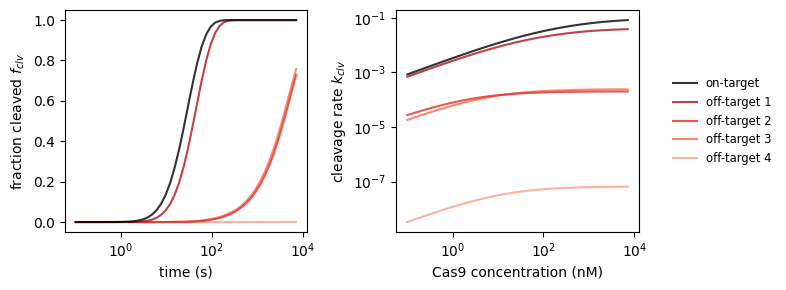

In [21]:
_, axs_clv = plt.subplots(1, 2, figsize=(8, 3))

# plot 1: cleaved fraction vs time
dt = np.logspace(-1, np.log10(7200))
binding_rate = k_on_ref * concentration

for i, stc in enumerate(protein_sequence_complexes):
    f_clv = stc.get_cleaved_fraction(dt, binding_rate)
    axs_clv[0].plot(
        dt, f_clv,
        label=('on-target' if i == 0 else f'off-target {i}'),
        color=('black' if i == 0 else plt.get_cmap('Reds_r')(i/6)),
        ls='solid',
        alpha=.8, zorder=2 + .1 * (5 - i)
    )
axs_clv[0].set_xscale('log')
axs_clv[0].set_xlabel('time (s)')
axs_clv[0].set_ylabel('fraction cleaved $f_{clv}$')

# plot 2: cleavage rate vs time
dc = np.logspace(np.log10(conc_min), np.log10(conc_max))

for i, stc in enumerate(protein_sequence_complexes):
    k_fit = [get_cleavage_rate(stc, k_on_ref * conc) for conc in dc]
    axs_clv[1].plot(
        dt, k_fit,
        label=('on-target' if i == 0 else f'off-target {i}'),
        color=('black' if i == 0 else plt.get_cmap('Reds_r')(i/6)),
        ls='solid',
        alpha=.8, zorder=2 + .1 * (5 - i)
    )
axs_clv[1].set_xscale('log')
axs_clv[1].set_yscale('log')
axs_clv[1].set_xlabel('Cas9 concentration (nM)')
axs_clv[1].set_ylabel('cleavage rate $k_{clv}$')

axs_clv[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5),
                  fontsize='small', edgecolor='None')

plt.tight_layout()

### 2.2 Binding activity
For some applications, we are interested in the binding activity of catalytically inactive dCas9. CRISPRzip makes predictions about this too. See how our selection of on- and off-targets get bound as a function of time. Also, note that on on-targets the R-loop forms successfully, whereas off-targets are mostly only bound at their PAM site.


In [22]:
# USER INPUT

# 'k_on_ref' is the association rate at 1 nM (s⁻¹)
k_on_ref = 1E-2
concentration = 5  # nM

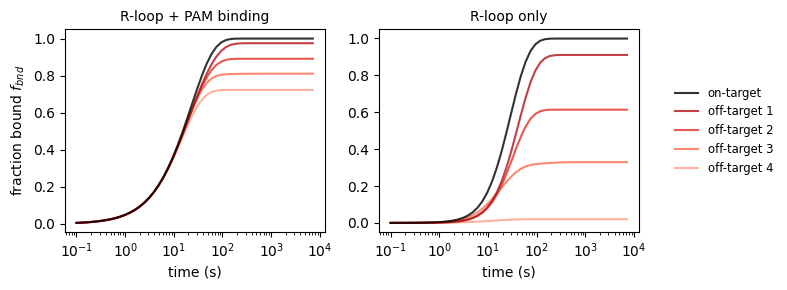

In [23]:
_, axs_bnd_t = plt.subplots(1, 2, figsize=(8, 3))

# plot 1 & 2: bound fraction vs time
dt = np.logspace(-1, np.log10(7200))
binding_rate = k_on_ref * concentration

for i, stc in enumerate(protein_sequence_complexes):
    f_bnd_inclpam = stc.get_bound_fraction(dt, binding_rate, pam_inclusion=1)
    axs_bnd_t[0].plot(
        dt, f_bnd_inclpam,
        label=('on-target' if i == 0 else f'off-target {i}'),
        color=('black' if i == 0 else plt.get_cmap('Reds_r')(i/6)),
        ls='solid',
        alpha=.8, zorder=2 + .1 * (5 - i)
    )

    f_bnd_exclpam = stc.get_bound_fraction(dt, binding_rate, pam_inclusion=0)
    axs_bnd_t[1].plot(
        dt, f_bnd_exclpam,
        label=('on-target' if i == 0 else f'off-target {i}'),
        color=('black' if i == 0 else plt.get_cmap('Reds_r')(i/6)),
        ls='solid',
        alpha=.8, zorder=2 + .1 * (5 - i)
    )

axs_bnd_t[0].set_xscale('log')
axs_bnd_t[0].set_xlabel('time (s)')
axs_bnd_t[0].set_ylabel('fraction bound $f_{bnd}$')
axs_bnd_t[0].set_title("R-loop + PAM binding", fontsize='medium')

axs_bnd_t[1].set_xscale('log')
axs_bnd_t[1].set_xlabel('time (s)')
axs_bnd_t[1].set_title("R-loop only", fontsize='medium')

axs_bnd_t[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5),
                  fontsize='small', edgecolor='None')
plt.tight_layout()

This time, we might interested in how much target is bound as function of concentration. Again, we can fit a curve to get a physical parameter out, this time, the binding constant $K_D$. Below, we show what this could look like for the on-target.

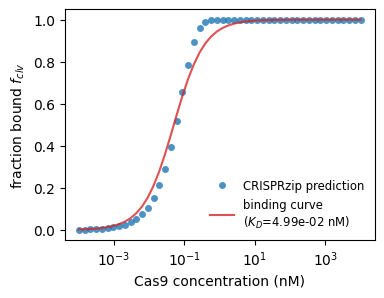

In [24]:
from scipy.optimize import curve_fit

_, axs_fit = plt.subplots(1, 1, figsize=(4, 3))

incub_time = 24 * 60  # sec (= 24h)

def get_binding_const(stc, ref_binding_rate):
    dc = np.logspace(-3, 5)
    f_bnd = stc.get_bound_fraction(incub_time, ref_binding_rate * dc)
    with np.errstate(over='ignore'): # ignore RuntimeWarning: overflow
        kd_fit = curve_fit(
            f=lambda c, kd: c / (c + kd),  # binding/Hill curve
            xdata=dc,
            ydata=f_bnd,
        )[0][0]
    return kd_fit

stc0 = protein_sequence_complexes[0]
kd_fit0 = get_binding_const(stc0, k_on_ref)
axs_fit.plot(
    np.logspace(-4,  4),
    stc0.get_bound_fraction(incub_time, k_on_ref * np.logspace(-4, 4)),
    marker='o', ls='None', markersize=5, markeredgecolor='None',
    label='CRISPRzip prediction',
    alpha=.8
)
axs_fit.plot(
    np.logspace(-4, 4),
    np.logspace(-4, 4) / (np.logspace(-4, 4) + kd_fit0),
    color='tab:red', alpha=.8,
    label=f'binding curve\n($K_D$={kd_fit0:.2e} nM)'
)
axs_fit.set_xscale('log')
axs_fit.set_xlabel('Cas9 concentration (nM)')
axs_fit.set_ylabel('fraction bound $f_{clv}$')
axs_fit.legend(fontsize='small', edgecolor='None')
plt.show()

With this tool, we can look at the binding strength of on- and off-targets.

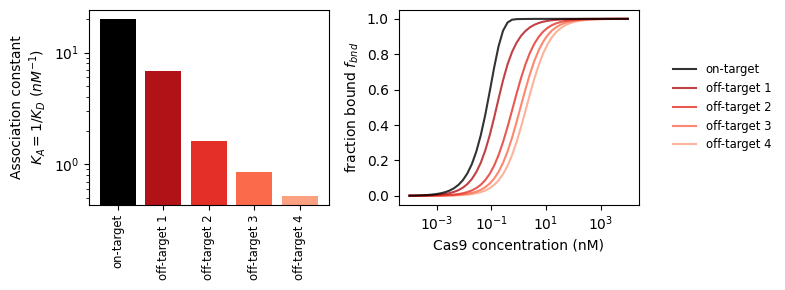

In [25]:
_, axs_bnd_c = plt.subplots(1, 2, figsize=(8, 3))

# plot 1: binding constants
axs_bnd_c[0].bar(
    np.arange(5),
    [1 / get_binding_const(stc, k_on_ref)
     for stc in protein_sequence_complexes],
    color=['black'] + [plt.get_cmap('Reds_r')(i/6) for i in range(1, 5)]
)
axs_bnd_c[0].set_yscale('log')
axs_bnd_c[0].set_ylabel('Association constant\n$K_A=1/K_D$ ($nM^{-1}$)')
axs_bnd_c[0].set_xticks(
    np.arange(5),
    ['on-target'] + [f'off-target {i}' for i in range(1, 5)],
    rotation=90, fontsize='small'
)

# plot 2: bound fraction vs concentration
incub_time = 24 * 50  # s (= 24h)
dc = np.logspace(-4,  4)  # concentration sweep

for i, stc in enumerate(protein_sequence_complexes):
    f_bnd_c = stc.get_bound_fraction(incub_time, k_on_ref * dc)
    axs_bnd_c[1].plot(
        dc, f_bnd_c,
        label=('on-target' if i == 0 else f'off-target {i}'),
        color=('black' if i == 0 else plt.get_cmap('Reds_r')(i/6)),
        ls='solid',
        alpha=.8, zorder=2 + .1 * (5 - i)
    )
axs_bnd_c[1].set_xscale('log')
axs_bnd_c[1].set_xlabel('Cas9 concentration (nM)')
axs_bnd_c[1].set_ylabel('fraction bound $f_{bnd}$')

axs_bnd_c[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5),
                    fontsize='small', edgecolor='None')
plt.tight_layout()